In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras import metrics

data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)

# aggregazione dati per celle
agg_by_cell = data.groupby(by = ['cell_num'])

In [9]:
num_data = []
## prepare dataset
for i, k in agg_by_cell:
    cell_i = agg_by_cell.get_group(i)
    # define input sequence
    series_i = cell_i['nr_people'].values
    series_i = series_i.reshape((len(series_i), 1))
    num_data.append(series_i)

In [12]:
print(num_data[:2][0])
print(len(num_data[:2]))

[[36.]
 [36.]
 [34.]
 ...
 [39.]
 [40.]
 [40.]]
2


In [32]:
final_data = hstack((num_data))
final_data.shape

(11808, 221)

In [33]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequences)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out
      # check if we are beyond the dataset
      if out_end_ix > len(sequences):
          break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 24, 8

# convert into input/output
X, y = split_sequences(final_data, n_steps_in, n_steps_out)

count = 0
for i in range(len(X)):
    count += 1
    print('inizia iterazione ', i)
    print(X[i], y[i])
    if count > 1: break
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))

inizia iterazione  0
[[ 36.  39.  41. ...  17. 104.  35.]
 [ 36.  38.  40. ...  17. 106.  36.]
 [ 34.  36.  38. ...  17. 107.  36.]
 ...
 [ 19.  19.  20. ...  17. 104.  35.]
 [ 18.  19.  19. ...  17. 103.  34.]
 [ 18.  18.  19. ...  17. 102.  34.]] [[ 18.  18.  19. ...  17. 102.  34.]
 [ 19.  19.  20. ...  17. 103.  34.]
 [ 21.  21.  22. ...  16. 102.  34.]
 ...
 [ 20.  21.  22. ...  16.  99.  33.]
 [ 20.  21.  22. ...  17.  99.  33.]
 [ 20.  21.  22. ...  17.  99.  33.]]
inizia iterazione  1
[[ 36.  38.  40. ...  17. 106.  36.]
 [ 34.  36.  38. ...  17. 107.  36.]
 [ 33.  35.  37. ...  17. 106.  35.]
 ...
 [ 18.  19.  19. ...  17. 103.  34.]
 [ 18.  18.  19. ...  17. 102.  34.]
 [ 18.  18.  19. ...  17. 102.  34.]] [[ 19.  19.  20. ...  17. 103.  34.]
 [ 21.  21.  22. ...  16. 102.  34.]
 [ 20.  21.  22. ...  17. 102.  34.]
 ...
 [ 20.  21.  22. ...  17.  99.  33.]
 [ 20.  21.  22. ...  17.  99.  33.]
 [ 19.  20.  20. ...  16.  96.  32.]]


In [53]:
#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
#train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=1)
#print(len(train_X), len(train_y), len(test_X), len(test_y), len(val_X), len(val_y))
split_train_test = int(len(X)*0.75)
train_X, test_X = X[:split_train_test], X[split_train_test:]
train_y, test_y = y[:split_train_test], y[split_train_test:]
print(len(train_X), len(train_y), len(test_X), len(test_y))

8832 8832 2945 2945


In [70]:
for i in range(220):
    print(final_data[i][0])

36.0
36.0
34.0
33.0
32.0
33.0
32.0
30.0
30.0
29.0
29.0
27.0
27.0
25.0
24.0
23.0
22.0
21.0
20.0
20.0
19.0
19.0
18.0
18.0
18.0
19.0
21.0
20.0
20.0
20.0
20.0
20.0
19.0
19.0
19.0
21.0
21.0
23.0
23.0
27.0
27.0
28.0
28.0
26.0
25.0
25.0
25.0
25.0
26.0
27.0
27.0
27.0
29.0
29.0
30.0
30.0
30.0
30.0
29.0
30.0
31.0
33.0
33.0
34.0
35.0
35.0
38.0
38.0
41.0
43.0
43.0
44.0
42.0
42.0
41.0
40.0
40.0
40.0
40.0
40.0
41.0
41.0
41.0
40.0
40.0
40.0
40.0
37.0
36.0
35.0
35.0
35.0
33.0
32.0
32.0
32.0
33.0
33.0
30.0
29.0
28.0
28.0
27.0
27.0
26.0
26.0
26.0
25.0
25.0
25.0
25.0
25.0
23.0
23.0
23.0
23.0
23.0
19.0
19.0
19.0
19.0
19.0
19.0
19.0
20.0
20.0
20.0
19.0
19.0
19.0
18.0
18.0
18.0
18.0
18.0
24.0
27.0
29.0
29.0
31.0
33.0
33.0
33.0
34.0
34.0
35.0
37.0
39.0
41.0
41.0
41.0
41.0
41.0
41.0
41.0
40.0
42.0
42.0
43.0
44.0
46.0
47.0
48.0
50.0
52.0
53.0
52.0
51.0
51.0
50.0
49.0
49.0
52.0
52.0
52.0
52.0
52.0
51.0
50.0
49.0
47.0
47.0
47.0
45.0
44.0
44.0
44.0
39.0
38.0
38.0
38.0
38.0
38.0
37.0
35.0
35.0
35.0
31.0
31.0
28.0


In [57]:
len(train_X)

8832

In [72]:
final_data.shape

(11808, 221)

In [40]:
# define model
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=n_input)) 
model.add(Dense(250, activation='relu', input_dim=n_input)) 
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse',  metrics=[metrics.mae, 'accuracy'])

# fit model
model.fit(train_X, train_y, epochs=100, verbose=2)

Epoch 1/100
 - 7s - loss: 2975.3870 - mean_absolute_error: 24.8422 - accuracy: 0.1038
Epoch 2/100
 - 6s - loss: 554.4429 - mean_absolute_error: 13.1929 - accuracy: 0.2620
Epoch 3/100
 - 6s - loss: 407.3064 - mean_absolute_error: 10.9528 - accuracy: 0.3880
Epoch 4/100
 - 6s - loss: 370.6592 - mean_absolute_error: 10.5689 - accuracy: 0.4299
Epoch 5/100
 - 6s - loss: 337.9449 - mean_absolute_error: 10.1208 - accuracy: 0.4505
Epoch 6/100
 - 7s - loss: 306.8918 - mean_absolute_error: 9.5877 - accuracy: 0.4478
Epoch 7/100
 - 7s - loss: 308.1756 - mean_absolute_error: 9.7431 - accuracy: 0.4554
Epoch 8/100
 - 7s - loss: 288.5802 - mean_absolute_error: 9.3435 - accuracy: 0.4580
Epoch 9/100
 - 7s - loss: 271.8673 - mean_absolute_error: 9.2173 - accuracy: 0.4611
Epoch 10/100
 - 7s - loss: 252.1259 - mean_absolute_error: 8.6507 - accuracy: 0.4718
Epoch 11/100
 - 7s - loss: 260.0953 - mean_absolute_error: 8.8916 - accuracy: 0.4704
Epoch 12/100
 - 7s - loss: 242.7515 - mean_absolute_error: 8.5262 - 

Epoch 98/100
 - 8s - loss: 145.5324 - mean_absolute_error: 6.2798 - accuracy: 0.5172
Epoch 99/100
 - 7s - loss: 147.7931 - mean_absolute_error: 6.3540 - accuracy: 0.5085
Epoch 100/100
 - 8s - loss: 146.6370 - mean_absolute_error: 6.2983 - accuracy: 0.5191


In [44]:
predicted = np.array([])
for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_input))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0])

print(len(test_y))
var4diff2 = len(test_y)
print('shape ',test_y.shape )
exp_y = test_y.reshape((test_y.shape[0] * test_y.shape[1]))    
expected = exp_y    
print(len(expected))
print(len(predicted)) 

2945
shape  (2945, 1768)
5206760
5206760


Mean Absolute Error =  8.447554813555833


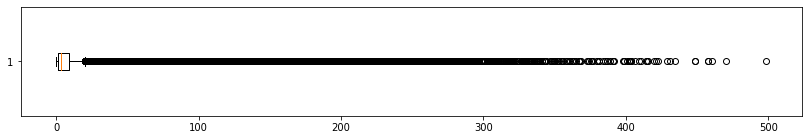

In [45]:
difference = abs(predicted - expected)
print('Mean Absolute Error = ', np.mean(difference))
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert = False)
plt.show()

In [50]:
shape_i = final_data.shape[1] * n_steps_out 
print(shape_i)


1768


In [51]:
difference2 = difference.reshape( var4diff2, shape_i)
print(difference2.shape)

(2945, 1768)


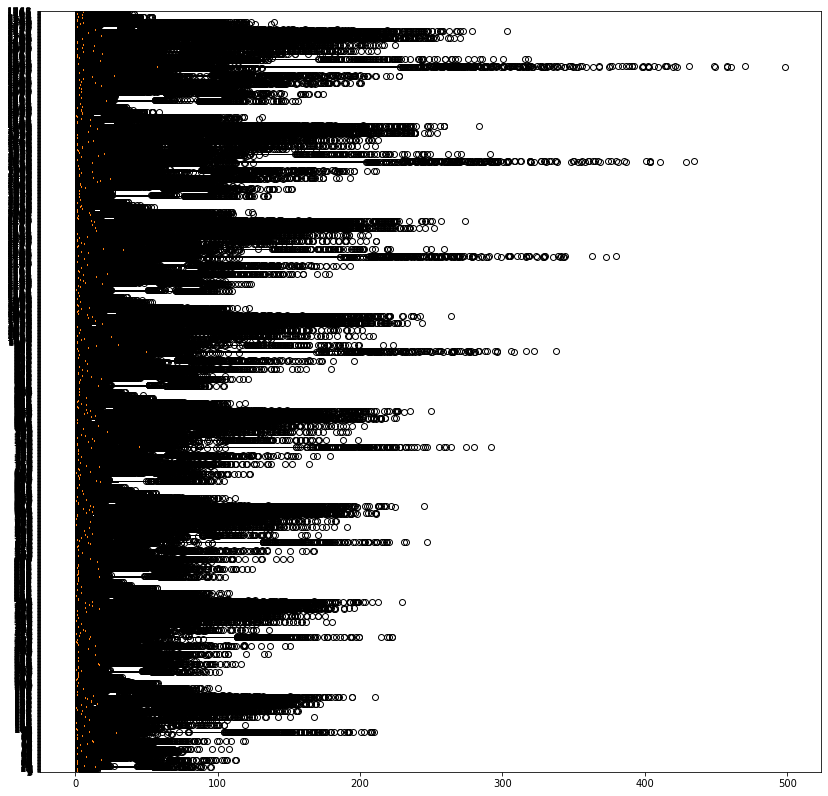

In [48]:


plt.figure(figsize = (14,14))
plt.boxplot(difference2, vert = False)
plt.show()